# Word2vec
可參考 
* http://nbviewer.jupyter.org/url/b81.org/s/math_intro11.ipynb

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np


In [2]:
# 設定環境變數來控制 keras, theano
import os
os.environ['KERAS_BACKEND']="tensorflow"
os.environ['THEANO_FLAGS']="floatX=float32, device=cuda"

### 用 jieba 斷詞

In [3]:
import jieba
jieba.set_dictionary('dict.txt.big')
" - ".join(jieba.cut("今天天氣很好"))

Building prefix dict from /home/tjw/src/HackNTU_Data_2017/Week08/dict.txt.big ...
Loading model from cache /tmp/jieba.uabe345d172aa2c353a2c9ed1c2ff896a.cache
Loading model cost 0.998 seconds.
Prefix dict has been built succesfully.


'今天天氣 - 很 - 好'

## 下載資料

In [4]:
if not os.path.isfile("sdyxz_all.txt"):    
    with open("sdyxz_all.txt","w") as outf:
        for i in range(1, 41):
            r = urlopen('http://www.millionbook.net/wx/j/jingyong/sdyxz/%03d.htm'%i)
            html = r.read().decode('cp950', "ignore")
            bs = BeautifulSoup(html, 'lxml')
            text = bs.findAll('td')[6].get_text()
            if len(text)<100:
                print("error")
                break
            print (i, len(text))
            outf.write(text)

In [5]:
# 忽略不要的詞
ignore_words = set("，。*「」：？\n\u3000！、…』『《》-")
# 自訂辭典
jieba.add_word("黃蓉")
jieba.suggest_freq("黃蓉", True)
jieba.add_word("郭靖")
jieba.suggest_freq("郭靖", True)
with open("sdyxz_all.txt", "r") as f:
    words = [w for w in jieba.cut(f.read()) if w not in ignore_words]
print("len=", len(words))
print(words[:100])

len= 440570
['第一回', '風雪', '驚變', '錢塘江', '浩浩', '江水', '日日夜夜', '無窮', '無休', '的', '從', '臨安', '牛家村', '邊', '繞過', '東流', '入海', '江畔', '一排', '數十株', '烏', '柏樹', '葉子', '似', '火燒', '般紅', '正是', '八月', '天時', '村前村後', '的', '野草', '剛', '起始', '變黃', '一抹', '斜陽', '映照', '之下', '更增', '了', '幾分', '蕭索', '兩株', '大', '松樹', '下圍', '著', '一堆', '村民', '男男女女', '和', '十幾個', '小孩', '正自', '聚精會神', '的', '聽', '著', '一個', '瘦削', '的', '老者', '說話', '那', '說話', '人五', '十來', '歲', '年紀', '一件', '青布', '長袍', '早洗', '得', '褪成', '了', '藍灰色', '只', '聽', '他', '兩片', '梨花', '木板', '碰', '了', '幾下', '左手', '中', '竹棒', '在', '一面', '小', '羯鼓', '上', '敲起', '得', '得', '連聲', '唱道']


### 先處理掉少用字

In [6]:
# 總共有多少種字？
len(set(words))

47156

我們只考慮最常用的 10000 字， 其他字用 UNK 取代

In [7]:
import collections
# 先統計字數
counter = collections.Counter(words)
# 可以看一下 counter 是的內容

In [8]:
def sep_words(words):
    for w in words:
        if counter[w]<3:
            for c in w:
                yield c
        else:
            yield w
words = list(sep_words(words))
len(words)

491260

In [9]:
counter = collections.Counter(words)


In [10]:
# 最常見的 30 個字
counter.most_common(30)

[('的', 11174),
 ('了', 10257),
 ('道', 7119),
 ('他', 6933),
 ('是', 6373),
 ('我', 5473),
 ('你', 5186),
 ('在', 5042),
 ('郭靖', 3364),
 ('也', 3086),
 ('不', 3050),
 ('她', 2659),
 ('得', 2640),
 ('又', 2622),
 ('這', 2561),
 ('那', 2524),
 ('黃蓉', 2493),
 ('去', 2225),
 ('上', 2098),
 ('一', 2001),
 ('人', 1916),
 ('中', 1867),
 ('說', 1857),
 ('卻', 1777),
 ('有', 1728),
 ('來', 1697),
 ('著', 1692),
 ('已', 1682),
 ('到', 1678),
 ('見', 1559)]

In [11]:
vocabulary_size = sum(x>2 for x in counter.values())
print(vocabulary_size)
wordfreq = counter.most_common(vocabulary_size-1)


# 建立 編號: 字 的對照表
num2word = ['UNK'] + [w for (w, _) in wordfreq]
freq = np.array([0]+[n for (_, n) in wordfreq], dtype="float64")
freq[0] = len(words) - freq.sum()
# 建立一個 字: 編號 的對照表
word2num = {w: i for i, w in enumerate(num2word)}

# 把 words 轉成對定的編號
data = np.array([word2num.get(word, 0) for word in words])
# 不需要 words 了
del words
del wordfreq
freq[:10]

17186


array([  1381.,  11174.,  10257.,   7119.,   6933.,   6373.,   5473.,
         5186.,   5042.,   3364.])

看一下目前的狀況

In [12]:
print(data[:20])
print(" - ".join(num2word[n] for n in data[:20]))

[  509    20   159  8099   479   928 12827  4626  4626  4729 15529  4678
    78  2509     1    70   693   877   451  4213]
第 - 一 - 回 - 風雪 - 驚 - 變 - 錢塘江 - 浩 - 浩 - 江水 - 日日夜夜 - 無窮 - 無 - 休 - 的 - 從 - 臨安 - 牛家村 - 邊 - 繞過


生成 skip-gram 模型的 batch

keywords skipgram, cbow, n-gram

In [13]:
import keras.backend as K

Using TensorFlow backend.


In [14]:
from keras.layers import Embedding, Dense, Flatten, Input
from keras.models import Sequential, Model
import keras.backend as K
import tensorflow as tf

# vector 的維度
embedding_size = 64

# 這其實只是線性映射，只不過輸入不是 one hot 而是 integer， 所以等同查表
word2vec = Sequential()
word2vec.add(Embedding(vocabulary_size, embedding_size, input_length=1))
word2vec.add(Flatten())
train_input = word2vec.inputs[0]
embeddings = word2vec.layers[0].embeddings 

# 對應到的 context
train_labels = Input(shape=(1,), dtype="int32")

# 這裡利用 tensorflow 的 nce_loss
nce_W = K.variable(K.random_normal((vocabulary_size, embedding_size),stddev=(embedding_size)**-0.5))
loss = K.mean(tf.nn.nce_loss(
                     weights=nce_W,
                     biases=K.zeros((vocabulary_size,)),
                     labels=train_labels,
                     inputs=word2vec.output,
                     num_sampled=64, # Number of negative examples to sample.
                     num_classes=vocabulary_size))

# 利用 tensorflow 的 optimizer
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# 之後要拿來檢驗的例子
valid_examples = np.array([word2num[x] for x in ["你", "我", "郭靖", "黃蓉", "聽", "梅超風", "自己", "武功"]])
#valid_examples = np.array(np.random.choice(100, size=16, replace=False)+1)
valid_size = len(valid_examples)
valid_dataset = K.constant(valid_examples[:, None], "int32")
valid_embeddings = word2vec(valid_dataset)

# 正規化 embeddings, 來找 nearest neighbor 
normalized_embeddings = K.l2_normalize(embeddings, 1)
similarity = K.dot(valid_embeddings, K.transpose(normalized_embeddings))

# Add variable initializer.
init = tf.global_variables_initializer()

In [15]:
def skipgram_batch(data, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window    
    context_length = skip_window*2+1
    X = np.ndarray(shape=batch_size, dtype=np.int32)
    Y = np.ndarray(shape=batch_size, dtype=np.int32)
    idx = 0
    while True:
        for i in range(0, batch_size, num_skips):
            X[i:i+num_skips] = data[idx+skip_window]            
            context = data[idx:idx+context_length][np.arange(context_length) != skip_window]        
            # subsampling 機率
            #p = np.ones(2*skip_window)/2/skip_window
            Y[i:i+num_skips] = np.random.choice(context, size=num_skips, replace=False)
            idx = (idx+1)%(len(data)-context_length)
        yield X[:, None], Y
# 測試看看
X,Y = next(skipgram_batch(data, 20, 4, 3))
for x,y in zip(X, Y):
    print("{} -> {}".format(num2word[x[0]], num2word[y]) )

風雪 -> 一
風雪 -> 變
風雪 -> 錢塘江
風雪 -> 回
驚 -> 風雪
驚 -> 變
驚 -> 錢塘江
驚 -> 浩
變 -> 浩
變 -> 錢塘江
變 -> 風雪
變 -> 浩
錢塘江 -> 浩
錢塘江 -> 風雪
錢塘江 -> 浩
錢塘江 -> 驚
浩 -> 錢塘江
浩 -> 江水
浩 -> 變
浩 -> 浩


In [16]:
import time
t0 = time.time()
batch_gen = skipgram_batch(data, batch_size=128, num_skips=4, skip_window=3)
with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    for step in range(0,200001):
        X,Y = next(batch_gen)
        feed_dict = {train_input: X, train_labels: Y[:, None]}
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        if step >0 and step %10000 == 0:
            print(step, "average loss", average_loss/2000, time.time()-t0)
            average_loss = 0
        if step % 50000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = num2word[valid_examples[i]]
                nearest = (-sim[i, :]).argsort()[1:8 + 1]
                print(valid_word, [num2word[x] for x in nearest])
    final_embeddings = normalized_embeddings.eval()

你 ['熹微', '護身', '蠻子', '三招', '年來', '奇經八脈', '是友', '郭靖頭']
我 ['雖大', '大漢', '權', '二字', '黃蓉竟', '稍定', '偏偏', '拔足']
郭靖 ['竭', '千丈', '時日', '嗒', '背囊', '打定', '崇', '生出']
黃蓉 ['已漸', '愕然', '用力', '悶聲不響', '全神', '急退', '白饒', '拍了拍']
聽 ['不保', '去取', '牛皮', '負起', '之念', '東道', '巧合', '流水']
梅超風 ['都給', '方桌', '耳根子', '一起', '拳擊', '外號', '短兵相接', '寒光']
自己 ['早', '郭靖頭', '紅', '悲從中來', '紛紛', '蠻幹', '一撒', '戰場']
武功 ['蓬頭', '金馬', '忙', '閒著', '掌教', '偶', '郭靖正', '登']
10000 average loss 113.828446667 19.020378828048706
20000 average loss 27.2152623873 36.94931769371033
30000 average loss 25.465784616 55.5016770362854
40000 average loss 25.24410286 74.79843664169312
50000 average loss 25.1046208923 93.62721991539001
你 ['我', '你們', '您', '老毒物', '咱們', '老頑童', '麼', '爹爹']
我 ['你', '老頑童', '老毒物', '黃老邪', '人家', '的話', '爹爹', '別人']
郭靖 ['歐陽克', '梅超風', '穆念慈', '華箏', '周伯通', '程瑤迦', '洪七公', '歐陽鋒']
黃蓉 ['穆念慈', '完顏康', '陸冠英', '洪七公', '歐陽鋒', '周伯通', '那書生', '楊康']
聽 ['有人', '盼', '聽到', '剩下', '聲', '兩聲', '身後', '回答']
梅超風 ['裘千丈', '楊兄弟', '陸乘風', '恍然大悟', '簡長老', '雷安答', '侯通海', '歐陽克

In [17]:
def find_sim(v, num=10):
    if isinstance(v, str):
        v = w2v(v)
    return [num2word[x] for x in  (final_embeddings @ v).argsort()[-num-1:-1][::-1]]
def w2v(w):
    return final_embeddings[word2num.get(w, 0)] 
find_sim(w2v('黃藥師'))

['歐陽鋒', '洪七公', '歐陽克', '柯鎮惡', '論語', '魯有腳', '和緩', '急收', '之德', '完顏康']

In [18]:
find_sim('吃')

['碗', '粥', '菜', '一碗', '飯', '烤', '白菜', '碗飯', '飯菜', '湯']

In [19]:
find_sim(w2v('西毒')+w2v('洪七公')-w2v('北丐'))

['完顏康', '歐陽克', '黃藥師', '裘千仞', '郭靖', '多言', '舉手', '簡長老', '良機', '咬緊牙關']

In [20]:
find_sim( w2v('郭靖')+(w2v('穆念慈')-w2v('楊康')) )

['穆念慈', '一燈', '華箏', '搖了', '黃蓉忽', '完顏康', '洪七公', '淒然', '郭靖呆', '追捕']

In [21]:
find_sim( w2v('洪七公')+(w2v('蛤蟆功')-w2v('歐陽鋒')) )

['小道士', '人用', '七十二路', '各家', '旁門左道', '剋星', '真實', '化開', '似非', '拳路']

In [22]:
find_sim(w2v('降龍十八掌')- w2v("洪七公") +w2v('歐陽鋒'))

['掌法', '招術', '精微', '點穴', '打狗棒法', '總綱', '精妙', '空明拳', '力道', '越女劍']

In [23]:
# 用 t-sne 降低維度
from sklearn.manifold import TSNE
samples = 500
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(final_embeddings[:samples])
labels = num2word[1:samples]

In [24]:
# 從 00Download.ipynb 來的
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os.path
from urllib.request import urlopen
def download_req(req, filename):
    total = int(req.getheader("Content-Length"))
    with open(filename,'wb') as f:
        i = 0
        for data in iter(lambda: req.read(8192), b""):  
            i+=1
            f.write(data)
            print("\rdownloading: %5.1f%%"%(i*8192*100.0/total), end="")

# 字體下載
font_filename = 'NotoSansCJKtc-hinted.zip'
font_url = "https://noto-website-2.storage.googleapis.com/pkgs/"+font_filename
# 改變這行才能真正下載
if not (os.path.isfile(font_filename) and os.path.getsize(font_filename)==121247052):
    with urlopen(font_url) as req:
        download_req(req, "NotoSansCJKtc-hinted.zip")
# Extract Font files
import zipfile
with zipfile.ZipFile(font_filename) as zf:
    for f in zf.namelist():
        if f.endswith('.otf'):
            print("extract", f)
            zf.extract(f)

fp = matplotlib.font_manager.FontProperties(fname = 'NotoSansCJKtc-Regular.otf')
matplotlib.font_manager.fontManager.ttffiles.append(fp.get_file())
font_entry = matplotlib.font_manager.FontEntry(fp.get_file(), name=fp.get_name(),
                                               style=fp.get_style(), variant=fp.get_variant(),
                                              weight=fp.get_weight(), stretch=fp.get_stretch(), size=fp.get_size())

matplotlib.font_manager.fontManager.ttflist.append(font_entry)
plt.rcParams['font.family'] = fp.get_name()

extract NotoSansCJKtc-Black.otf
extract NotoSansCJKtc-Bold.otf
extract NotoSansCJKtc-DemiLight.otf
extract NotoSansCJKtc-Light.otf
extract NotoSansCJKtc-Medium.otf
extract NotoSansCJKtc-Regular.otf
extract NotoSansCJKtc-Thin.otf
extract NotoSansMonoCJKtc-Bold.otf
extract NotoSansMonoCJKtc-Regular.otf


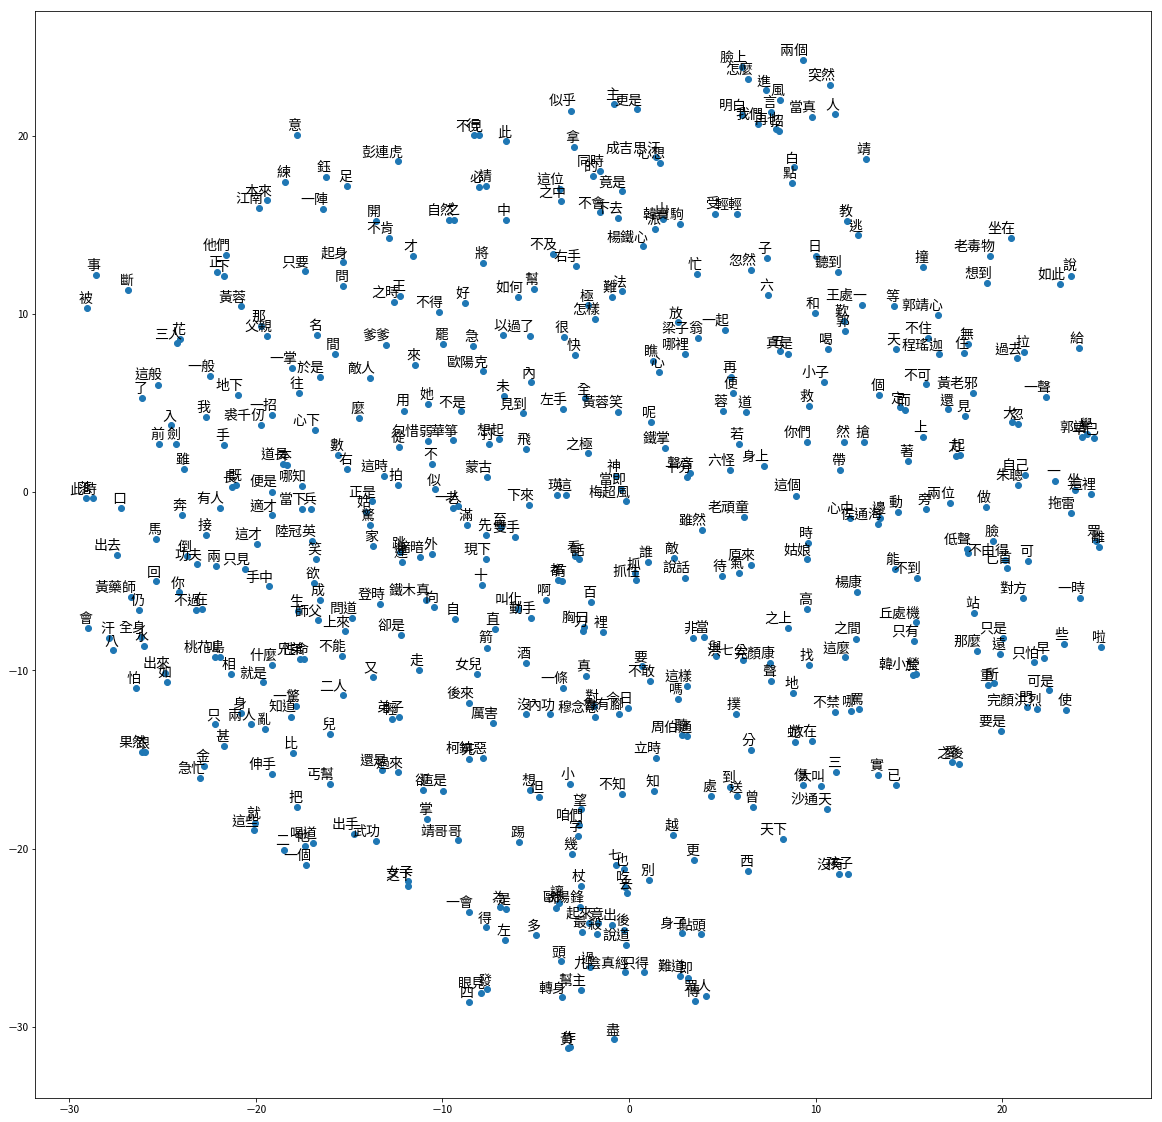

In [25]:
# 畫出來

plt.figure(figsize=(20,20))
plt.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1])
for i, label in enumerate(labels):
    x, y = low_dim_embs[i]
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=14,
                 ha='right',
                 va='bottom')